## Alternative aproach to MGA using euclidean distance

In [1]:
import pypsa
import pandas as pd
import numpy as np

In this section a series of coppies of seperate disconected busses/networks is generated. They are all in the same PyPSA model, but will not influence each other

### Network 1
This is a simple network with a limited number of variables

In [35]:
# Creating a networks and adding a MGA class to the network object
network1 = pypsa.Network()
class MGA:
    pass
network1.MGA = MGA
network1.MGA.nr_of_networks = 5

# Setting number of snapshots to simulate
network1.set_snapshots(range(2))
# Looping over the number of networks to be created,
# and altering the bus name and the generator names.
# The last number in the generator name indicates which instance
# of the networks they belong to
for i in range(network1.MGA.nr_of_networks):
    
    # Add a bus to the network.
    bus_nr = 'bus'+str(i+1)
    network1.add("Bus",bus_nr,x=i,y=i%2)

    # Add a coal power plant to the bus.
    network1.add("Generator",'coal'+str(i+1),bus=bus_nr,
           type = 'coal',
           committable=True,
           p_min_pu=0.2,
           marginal_cost=15,
           capital_cost = 100,
           p_nom_extendable=True)

    # Add a gas power plant to the bus.
    network1.add("Generator",'gas'+str(i+1),bus=bus_nr,
           type = 'gas',
           committable=True,
           marginal_cost=20,
           capital_cost = 75,
           p_min_pu=0,
           p_nom_extendable=True)
    
    # Add a gas power plant to the bus.
    network1.add("Generator",'bio'+str(i+1),bus=bus_nr,
           type = 'bio',
           committable=True,
           marginal_cost=18,
           capital_cost = 115,
           p_min_pu=0,
           p_nom_extendable=True)
    # Add load to the bus.
    network1.add("Load",'load'+str(i+1),bus=bus_nr,p_set=[6000,1200])

(<matplotlib.collections.PathCollection at 0x1698a5f5b70>,)

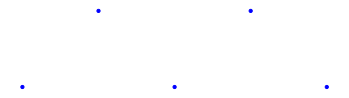

In [36]:
network1.plot()

### Network 2
A much more complex network, simulating an entire year of production with hourly data

In [37]:
def annuity(n,r):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20,0.05)*20 = 1.6"""

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n
    
# Create network
network2 = pypsa.Network()
class MGA:
    pass
network2.MGA = MGA
network2.MGA.nr_of_networks = 5

# Import of data
hours_in_2018=pd.date_range('2017-06-01T00:00Z','2017-07-01T00:00Z',freq='H') #'2017-12-31T23:00Z'
network2.set_snapshots(hours_in_2018)
# wind data
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv',sep=';',index_col=0)
CF_wind=df_onshorewind['ESP'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network2.snapshots]]
capital_cost_onshorewind=annuity(30,0.07)*910000*(1+0.033) # in €/MW
# solar data
df_solar = pd.read_csv('data/pv_optimal.csv',sep=';',index_col=0)
CF_solar=df_solar['ESP'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network2.snapshots]]
capital_cost_solar=annuity(25,0.07)*425000*(1+0.03) # in €/MW
# OCGT data
capital_cost_OCGT=annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost=21.6 # in €/MWh_th
efficiency=0.39
marginal_cost_OCGT=fuel_cost/efficiency # in €/MWh_el

# electricity demand data
df_elec = pd.read_csv('data/Total Load - Day Ahead _ Actual_DK_201701010000-201801010000.csv',sep=',',index_col=0) # in MWh
df_elec = df_elec[:network2.snapshots.size]

# As with network1, i loop over the number of networks to be generated, 
# altering the index on the names
for i in range(network2.MGA.nr_of_networks):

    # Add a electricity bus to the network
    bus_nr = 'bus'+str(i+1)
    network2.add("Bus",bus_nr)

    # add load to the bus
    network2.add("Load","load"+str(i+1), 
                bus=bus_nr, 
                p_set=df_elec['Actual Total Load [MW] - Denmark (DK)'].tolist())
    
    # add onshore wind generator
    network2.add("Generator",
                "onshorewind"+str(i+1),
                bus=bus_nr,
                p_nom_extendable=True,
                #carrier="onshorewind",
                #p_nom_max=1000,
                capital_cost = capital_cost_onshorewind,
                marginal_cost = 0,
                p_max_pu = CF_wind)

    # add solar PV generator
    network2.add("Generator",
                "solar"+str(i+1),
                bus=bus_nr,
                p_nom_extendable=True,
                #carrier="solar",
                #p_nom_max=1000,
                capital_cost = capital_cost_solar,
                marginal_cost = 0,
                p_max_pu = CF_solar)


    network2.add("Generator",
                "OCGT"+str(i+1),
                bus=bus_nr,
                p_nom_extendable=True,
                #carrier="gas",
                p_nom_max=4000,
                capital_cost = capital_cost_OCGT,
                marginal_cost = marginal_cost_OCGT
               )

As with the regular MGA aproach the network is first solved without the new objective function

In [55]:
    # Initial solution of network, with non MGA objective function 
    network = network2
    network.lopf(network.snapshots,solver_name='gurobi')

INFO:pypsa.pf:Slack bus for sub-network 0 is bus1
INFO:pypsa.pf:Slack bus for sub-network 1 is bus2
INFO:pypsa.pf:Slack bus for sub-network 2 is bus3
INFO:pypsa.pf:Slack bus for sub-network 3 is bus4
INFO:pypsa.pf:Slack bus for sub-network 4 is bus5
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x14436_copy
  Lower bound: 5125790576.703593
  Upper bound: 5125790576.703593
  Number of objectives: 1
  Number of constraints: 28841
  Number of variables: 14436
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 14436
  Number of nonzeros: 45511
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination me

('ok', 'optimal')

The initial solution will alway contain a set of identical networks. The last number in the generators describe which network they belong to

In [67]:
network.generators.p_nom_opt

onshorewind1    9273.042875
solar1          1187.293873
OCGT1           4000.000000
onshorewind2    9273.042875
solar2          1187.293873
OCGT2           4000.000000
onshorewind3    9273.042875
solar3          1187.293873
OCGT3           4000.000000
onshorewind4    9273.042875
solar4          1187.293873
OCGT4           4000.000000
onshorewind5    9273.042875
solar5          1187.293873
OCGT5           4000.000000
Name: p_nom_opt, dtype: float64

In [57]:
    # Saving the value of the old objective function.
    old_objective_value = network.model.objective()
    old_objective_value/network.MGA.nr_of_networks/1000000

1025.1581153407194

## Defining an alternative objective function 

In this alternative aproach, the MGA objective function seeks to maximize the distance between a number $N$ of networks with $K$ variables. The distance between the networks can be described with the squared euqlidian distance for an $n$ dimentional vector. 

$ d = \sum_{i=1}^n{(x_{i}-x_{i})^2} $

By summing the distance from each network to all other networks, an expression describing the distinction between the networks is found. The following objective function will try to maximize the distance between all networks:

$N$ : Number of independent networks 

$K$ : Number of variables in each network

$x$ : 2D vector containing all variables. 1st index specifies the variable and 2nd index specifies the network

$ p= - \frac{1}{2}  \sum_i^N{\sum_j^N{\sum_k^K{(x_{k,i}-x_{k,j})^2}}}  $ 

The drawback is that the objective function is now a square function, increasing computation time, however gurobi is capable of handeling it, at least for smaller energy systems

In [58]:
def extra_functionality(network, snapshots,  MGA_slack = 0.05):
    # Defining exstra functionality, that updates the objective function of the network
    # Default value for MGA_slack is 0.05 if nothing else is specified 
    import pyomo.environ as pyomo_env

    # Number of networks
    #N = int(list(network.generators_t.p.columns)[-1][-1]) 
    N = network.MGA.nr_of_networks
    # Generating a list of variables sorted after their variable index and network number
    # First index: Variable nr
    # Second index: Network number    
    gen_p_list = [[] for i in range(N)]
    for gen_p in network.model.generator_p:
        gen_p_network_idx = int(gen_p[0][-1])-1
        gen_p_list[gen_p_network_idx].append(gen_p)
    # Number of variables in each network
    K = len(gen_p_list[0]) 

    # Creating the MGA objective function
    MGA_objective = 0
    for i in range(N):
        for j in range(N):
            for k in range(K):
                if i < j:
                    gen_p1 = network.model.generator_p[gen_p_list[i][k]]
                    gen_p2 = network.model.generator_p[gen_p_list[j][k]]
                    MGA_objective += (gen_p1**2 + gen_p2**2 - 2*gen_p1*gen_p2 )
    # Changing sign of objective function to make it a minimization problem
    MGA_objective = - MGA_objective 
    #print (MGA_objective)

    # Adding new MGA objective function to network 
    network.model.mga_objective = pyomo_env.Objective(expr=MGA_objective)
    # Deactivate the old objective function and activate the MGA objective function.
    network.model.objective.deactivate()
    network.model.mga_objective.activate()
    # Add the MGA slack constraint.
    #network.model.mga_constraint = pyomo_env.Constraint(expr=network.model.objective.expr <= 
    #                                      (1 + MGA_slack) * old_objective_value)


    constraint0 = 0
    constraint1 = 0
    constraint2 = 0
    constraint3 = 0
    constraint4 = 0
    for i in range(3):
        constraint0 += network.generators.ix[i,'marginal_cost']*network.model.generator_p[gen_p_list[0][i]]
        constraint0 += network.generators.ix[i,'capital_cost']*network.model.generator_p[gen_p_list[0][i]]
        constraint1 += network.generators.ix[i,'marginal_cost']*network.model.generator_p[gen_p_list[1][i]]
        constraint1 += network.generators.ix[i,'capital_cost']*network.model.generator_p[gen_p_list[1][i]]
        constraint2 += network.generators.ix[i,'marginal_cost']*network.model.generator_p[gen_p_list[2][i]]
        constraint2 += network.generators.ix[i,'capital_cost']*network.model.generator_p[gen_p_list[2][i]]
        constraint3 += network.generators.ix[i,'marginal_cost']*network.model.generator_p[gen_p_list[3][i]]
        constraint3 += network.generators.ix[i,'capital_cost']*network.model.generator_p[gen_p_list[3][i]]
        constraint4 += network.generators.ix[i,'marginal_cost']*network.model.generator_p[gen_p_list[4][i]]
        constraint4 += network.generators.ix[i,'capital_cost']*network.model.generator_p[gen_p_list[4][i]]
    
    network.model.mga_constraint0 = pyomo_env.Constraint(expr = constraint0<= (1 + MGA_slack) * old_objective_value/5)
    network.model.mga_constraint1 = pyomo_env.Constraint(expr = constraint1<= (1 + MGA_slack) * old_objective_value/5)
    network.model.mga_constraint2 = pyomo_env.Constraint(expr = constraint2<= (1 + MGA_slack) * old_objective_value/5)
    network.model.mga_constraint3 = pyomo_env.Constraint(expr = constraint3<= (1 + MGA_slack) * old_objective_value/5)
    network.model.mga_constraint4 = pyomo_env.Constraint(expr = constraint4<= (1 + MGA_slack) * old_objective_value/5)

In [71]:
def extra_functionality3(network, snapshots,  MGA_slack = 0.05):
    # Defining exstra functionality, that updates the objective function of the network
    # Default value for MGA_slack is 0.05 if nothing else is specified 
    import pyomo.environ as pyomo_env

    
    # Number of networks
    N = int(list(network.generators_t.p.columns)[-1][-1]) 
    # Generating a list of variables sorted after their variable index and network number
    # First index: Variable nr
    # Second index: Network number    
    gen_p_list = [[] for i in range(N)]
    for gen_p in network.model.generator_p:
        gen_p_network_idx = int(gen_p[0][-1])-1
        gen_p_list[gen_p_network_idx].append(gen_p)
    # Number of variables in each network
    K = len(gen_p_list[0]) 

    # Creating the MGA objective function
    MGA_objective = 0

    for i in range(N):
        for j in range(N):
            for k in range(K):
                if i < j:
                    gen_p1 = network.model.generator_p[gen_p_list[i][k]]
                    gen_p2 = network.model.generator_p[gen_p_list[j][k]]
                    MGA_objective += (gen_p1**2 + gen_p2**2 - 2*gen_p1*gen_p2 )
    # Changing sign of objective function to make it a minimization problem
    MGA_objective = - MGA_objective 
    print (MGA_objective)
    
    # Adding new MGA objective function to network 
    network.model.mga_objective = pyomo_env.Objective(expr=MGA_objective)
    # Deactivate the old objective function and activate the MGA objective function.
    network.model.objective.deactivate()
    network.model.mga_objective.activate()
    # Add the MGA slack constraint.
    network.model.mga_constraint = pyomo_env.Constraint(expr=network.model.objective.expr <= 
                                          (1 + MGA_slack) * old_objective_value)



In [59]:
def extra_functionality2(network, snapshots,  MGA_slack = 0.05):
    # Defining exstra functionality, that updates the objective function of the network
    # Default value for MGA_slack is 0.05 if nothing else is specified 
    import pyomo.environ as pyomo_env

    # Number of networks
    #N = int(list(network.generators_t.p.columns)[-1][-1]) 
    N = network.MGA.nr_of_networks
    # Generating a list of variables sorted after their variable index and network number
    # First index: Variable nr
    # Second index: Network number    
    gen_p_list = [[] for i in range(N)]
    for gen_p in network.model.generator_p_nom:
        gen_p_network_idx = int(gen_p[-1])-1
        gen_p_list[gen_p_network_idx].append(gen_p)



    gen_p_list_old = [[] for i in range(N)]
    for gen_p in network.model.generator_p:
        gen_p_network_idx = int(gen_p[0][-1])-1
        gen_p_list_old[gen_p_network_idx].append(gen_p)
    # Number of variables in each network
    K = len(gen_p_list[0]) 

    # Creating the MGA objective function
    MGA_objective = 0
    for i in range(N):
        for j in range(N):
            for k in range(K):
                if i < j:
                    gen_p1 = network.model.generator_p_nom[gen_p_list[i][k]]
                    gen_p2 = network.model.generator_p_nom[gen_p_list[j][k]]
                    MGA_objective += (gen_p1**2 + gen_p2**2 - 2*gen_p1*gen_p2 )
    # Changing sign of objective function to make it a minimization problem
    MGA_objective =  -MGA_objective 
    print (MGA_objective)

    # Adding new MGA objective function to network 
    network.model.mga_objective = pyomo_env.Objective(expr=MGA_objective)
    # Deactivate the old objective function and activate the MGA objective function.
    network.model.objective.deactivate()
    network.model.mga_objective.activate()
    # Add the MGA slack constraint.
    network.model.mga_constraint = pyomo_env.Constraint(expr=network.model.objective.expr <= 
                                          (1 + MGA_slack) * old_objective_value)


    constraint0 = 0
    constraint1 = 0
    constraint2 = 0
    constraint3 = 0
    constraint4 = 0
    for i in range(6):
        constraint0 += network.generators.ix[int(i/2),'marginal_cost']*network.model.generator_p[gen_p_list_old[0][i]]
        constraint1 += network.generators.ix[int(i/2),'marginal_cost']*network.model.generator_p[gen_p_list_old[1][i]]
        constraint2 += network.generators.ix[int(i/2),'marginal_cost']*network.model.generator_p[gen_p_list_old[2][i]]
        constraint3 += network.generators.ix[int(i/2),'marginal_cost']*network.model.generator_p[gen_p_list_old[3][i]]
        constraint4 += network.generators.ix[int(i/2),'marginal_cost']*network.model.generator_p[gen_p_list_old[4][i]]
    for i in range(3):
        constraint0 += network.generators.ix[i,'capital_cost']*network.model.generator_p_nom[gen_p_list[0][i]]
        constraint1 += network.generators.ix[i,'capital_cost']*network.model.generator_p_nom[gen_p_list[1][i]]
        constraint2 += network.generators.ix[i,'capital_cost']*network.model.generator_p_nom[gen_p_list[2][i]]
        constraint3 += network.generators.ix[i,'capital_cost']*network.model.generator_p_nom[gen_p_list[3][i]]
        constraint4 += network.generators.ix[i,'capital_cost']*network.model.generator_p_nom[gen_p_list[4][i]]
        
   
    print('#########################')
    print(constraint0)
    #network.model.mga_constraint0 = pyomo_env.Constraint(expr = constraint0<= (1 + MGA_slack) * old_objective_value/5)
    #network.model.mga_constraint1 = pyomo_env.Constraint(expr = constraint1<= (1 + MGA_slack) * old_objective_value/5)
    #network.model.mga_constraint2 = pyomo_env.Constraint(expr = constraint2<= (1 + MGA_slack) * old_objective_value/5)
    #network.model.mga_constraint3 = pyomo_env.Constraint(expr = constraint3<= (1 + MGA_slack) * old_objective_value/5)
    #network.model.mga_constraint4 = pyomo_env.Constraint(expr = constraint4<= (1 + MGA_slack) * old_objective_value/5)

### Solving network with MGA objective function

In [72]:
MGA_slack = 0.1
#Solve network with updated objective function
network.lopf(network.snapshots,\
             solver_name='gurobi',\
             extra_functionality=lambda network,\
             snapshots: extra_functionality3(network, snapshots, MGA_slack),
             solver_options = {'psdtol':0.1,'presolve':-1}) 

INFO:pypsa.pf:Slack bus for sub-network 0 is bus1
INFO:pypsa.pf:Slack bus for sub-network 1 is bus2
INFO:pypsa.pf:Slack bus for sub-network 2 is bus3
INFO:pypsa.pf:Slack bus for sub-network 3 is bus4
INFO:pypsa.pf:Slack bus for sub-network 4 is bus5
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

ERROR:pyomo.opt:Solver (gurobi) returned non-zero return code (1)
ERROR:pyomo.opt:Solver log:
Academic license - for non-commercial use only
Read LP format model from file C:\Users\Tim\AppData\Local\Temp\tmph7wq7xth.pyomo.lp
Reading time = 0.13 seconds
x14436: 28842 rows, 1

ERROR: Solver (gurobi) returned non-zero return code (1)
ERROR: Solver log: Academic license - for non-commercial use only Read LP
    format model from file
    C:\Users\Tim\AppData\Local\Temp\tmph7wq7xth.pyomo.lp Reading time = 0.13
    seconds x14436: 28842 rows, 14436 columns, 49131 nonzeros Changed value of
    parameter QCPDual to 1
       Prev: 0  Min: 0  Max: 1  Default: 0
    Changed value of parameter psdtol to 0.1
       Prev: 1e-06  Min: 0.0  Max: 1e+100  Default: 1e-06
    Parameter presolve unchanged
       Value: -1  Min: -1  Max: 2  Default: -1
    Optimize a model with 28842 rows, 14436 columns and 49131 nonzeros Model
    has 32445 quadratic objective terms Coefficient statistics:
      Matrix range     [2e-03, 8e+04] Objective range  [0e+00, 0e+00]
      QObjective range [4e+00, 8e+00] Bounds range     [4e+03, 4e+03] RHS
      range        [1e+00, 6e+09]
             Consider reformulating model or setting NumericFocus parameter to
             avoid numerical issues

ApplicationError: Solver (gurobi) did not exit normally

In [73]:
network.generators.p_nom_opt

onshorewind1    9273.042875
solar1          1187.293873
OCGT1           4000.000000
onshorewind2    9273.042875
solar2          1187.293873
OCGT2           4000.000000
onshorewind3    9273.042875
solar3          1187.293873
OCGT3           4000.000000
onshorewind4    9273.042875
solar4          1187.293873
OCGT4           4000.000000
onshorewind5    9273.042875
solar5          1187.293873
OCGT5           4000.000000
Name: p_nom_opt, dtype: float64

### Plotting funciton 

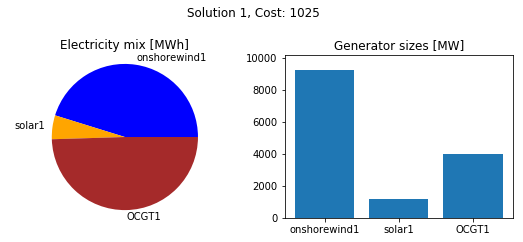

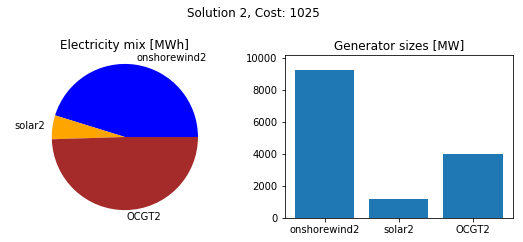

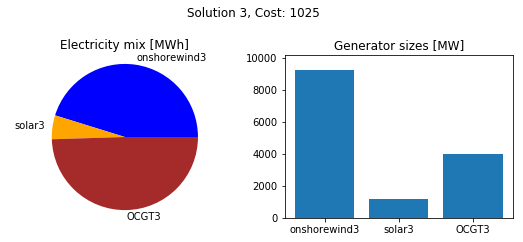

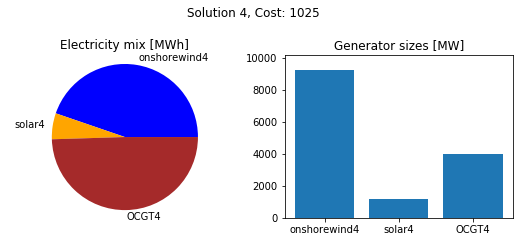

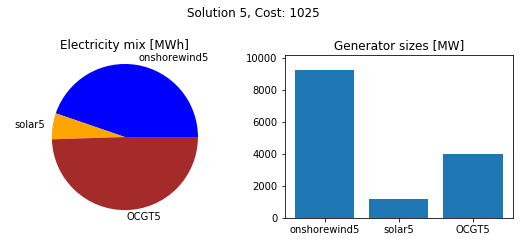

In [70]:
import matplotlib.pyplot as plt
labels = network.generators.index.tolist()
productions = [] # Production in MWh per technology
for generator in network.generators.index.tolist():
    productions.append(network.generators_t.p[generator].sum())

sizes=network.generators['p_nom_opt'] # Plant sizes in MW

generator_cost = network.generators['capital_cost']*sizes+productions*network.generators['marginal_cost']
network_cost = [] # Total cost for one year of opperation
for i in range(network.MGA.nr_of_networks):
    network_cost.append( int(sum(generator_cost[i*3:i*3+3])/1000000))
    
for idx in range(network.MGA.nr_of_networks):
    colors=['blue', 'orange', 'brown']
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=False)
    #plt.figure(idx+1)
    
    fig.suptitle('Solution '+str(idx+1) + ', Cost: ' + str(network_cost[idx]),y=1.1)
    
    axs[0].pie(productions[3*idx:3*idx+3], 
            colors=colors, 
            labels=labels[3*idx:3*idx+3], 
            wedgeprops={'linewidth':0})
    axs[0].axis('equal')
    axs[0].set_title('Electricity mix [MWh]', y=1)
    
    axs[1].bar([0,1,2],
               sizes[3*idx:3*idx+3], 
               width=0.8,
               bottom=-1)
    axs[1].set_ylim(0,max(sizes)*1.1)
    axs[1].set_xticks([0,1,2])
    axs[1].set_xticklabels(labels[3*idx:3*idx+3])
    axs[1].set_title('Generator sizes [MW]', y=1)

In [64]:
network.generators_t.p.loc[1].sum()

TypeError: cannot do index indexing on <class 'pandas.core.indexes.datetimes.DatetimeIndex'> with these indexers [1] of <class 'int'>

In [65]:
network.generators[network.generators['type']=='bio']

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,initial_status,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt


In [63]:
(1+MGA_slack)*old_objective_value/5000000

0.6468

In [64]:
print(network.model.mga_constraint0.expr)
print(network.model.objective.expr)

AttributeError: 'ConcreteModel' object has no attribute 'mga_constraint0'

In [43]:
print(network.model.generator_p_nom)

generator_p_nom


In [49]:
network.generators['p_nom_opt']

coal1    3427.946693
gas1     2000.000000
bio1     3000.000000
coal2    3003.677437
gas2     2000.000000
bio2     3000.000000
coal3    3003.677135
gas3     2000.000000
bio3     3000.000000
coal4    3003.677591
gas4     2000.000000
bio4     3000.000000
coal5    1350.554709
gas5     2000.000000
bio5     3000.000000
Name: p_nom_opt, dtype: float64